# Milestone 3: Independent Project

#### Author - Stacy Liu

### Overview

For this capstone project, we will use the SECOM manufacturing Data Set from the UCI Machine Learning Repository. The set is originally for semiconductor manufacturing, but in our case, we will assume that it is for the diaper manufacturing process.

I'll be using the following DFD to guide this project:
<img src="DFD_1.jpg">

**Data**
The dataset consists of two files:
- Dataset file SECOM: containing 1567 examples, each with 591 features, presented in a 1567 x 591 matrix
- Labels: file listing the classifications and date time stamp for each example

**Overview of Milestone 1**

In milestone 1, I prepared the manufacturing data for modeling by performing the following:
- Merged the feature and label datasets
- Split data into training/tuning/testing (70/15/15)
- Performed initial exploratory data analysis:
    - The label is highly imbalanced. Only a small percentage (6.6%) of the cases have defects.
    - All features are numeric.
    - Plotted scatter matrix for the features most correlated with the label. Most of those features have close to normal distribution. 
    - Some of the features appears to be correlated with each other (ex. feature 158 and 293). This may cause a colinearity problem when modeling. 
- Cleaned data by:
    - Removing features that have missing values in more than 30% of the dataset
    - Input mean for features with fewer missing values
    - Applied standard scalar to the features
- Addressed class imbalance problem using SMOTE
- Applied Wrapper forward selection to feature select:
    - Performance (using logistic regression and AOC curve as the error metric) started leveling off with the top 50 features
    
**Overview of Milestone 2**

 In Milestone 2, I built the following models to detect faulty products:

1. Decision Tree Model
2. Ensemble Model: Random Forest
3. SVM Model

Below are the results (on the tune set):

| Metric | Decision Tree  | Random Forest  | SVC  |
|------|------|------|------|
|   Accuracy  | 0.8213| 0.9191| 0.8213|
|   AUC  | 0.748| 0.756| 0.587|
|   Recall  | 0.5833| 0.25| 0.3333|
|   Precision  | 0.1590| 0.23| 0.1053|
|   F1 Score  | 0.25| 0.24| 0.16|

**Random Forest model** (entropy with max_depth of 15, max_features of 0.2, min_samples_leaf of 5, and 50 n_estimators) performed the best in terms of both accuracy and F1 score. 

However it did not generalize as well to the test set. The model prediction on the test set had an accuracy score of 0.8729 and F1 score of 0.1667.

**Overview of Milestone 3**

In Milestone 3, I built the following models to detect faulty products:
1. Simple neural network
2. DNN model

Below are the results (on the tune set):

| Metric | Simple NN  | DNN  |
|------|------|------|
|   Accuracy  | 0.90638| 0.90638|
|   AUC  | 0.675| 0.689|
|   Recall  | 0.1667| 0.0833|
|   Precision  | 0.1428| 0.0833|
|   F1 Score  | 0.1538| 0.0833|

While the DNN did slightly better in terms of AUC, Random Forest (from Milestone 2) is still the better option with accuracy of 0.9191 and AUC of 0.756 on the tune set. 

## Initial Loading of packages and dataset

In [1]:
# set global paramters
SEED = 2005

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, classification_report

In [3]:
#set global options
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 700)
pd.set_option("display.max_columns", 700)

#### Read in data

In [4]:
secom = pd.read_csv("secom.data", sep=' ', header=None)
labels = pd.read_csv("secom_labels.data", sep=' ', header=None, names = ['Label', 'Time'])
# convert time to datatime data type
labels['Time'] = pd.to_datetime(labels['Time'])

# concat the two dataframes
df = pd.concat([labels, secom], axis=1)

df.head(10)

,Label,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589
0,-1,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,117.5132,61.29,4.515,70.0,352.7173,10.1841,130.3691,723.3092,1.3072,141.2282,1.0,624.3145,218.3174,0.0,4.592,4.841,2834.0,0.9317,0.9484,4.7057,-1.7264,350.9264,10.6231,108.6427,16.1445,21.7264,29.5367,693.7724,0.9226,148.6009,1.0,608.1700,84.0793,NaN,NaN,0.0,0.0126,-0.0206,0.0141,-0.0307,-0.0083,-0.0026,-0.0567,-0.0044,7.2163,0.1320,NaN,2.3895,0.9690,1747.6049,0.1841,8671.9301,-0.3274,-0.0055,-0.0001,0.0001,0.0003,-0.2786,0.0,0.3974,-0.0251,0.0002,0.0002,0.1350,-0.0042,0.0003,0.0056,0.0000,-0.2468,0.3196,NaN,NaN,NaN,NaN,0.9460,0.0,748.6115,0.9908,58.4306,0.6002,0.9804,6.3788,15.88,2.639,15.94,15.93,0.8656,3.353,0.4098,3.188,-0.0473,0.7243,0.9960,2.2967,1000.7263,39.2373,123.0,111.3,75.2,46.2000,350.6710,0.3948,0.0,6.78,0.0034,0.0898,0.0850,0.0358,0.0328,12.2566,0.0,4.271,10.284,0.4734,0.0167,11.8901,0.41,0.0506,NaN,NaN,1017.0,967.0,1066.0,368.0,0.090,0.048,0.095,2.0,0.9,0.069,0.046,0.7250,0.1139,0.3183,0.5888,0.3184,0.9499,0.3979,0.160,0.0,0.0,20.95,0.333,12.49,16.713,0.0803,5.72,0.0,11.19,65.363,0.0,0.0,0.0,0.0,0.0,0.0,0.292,5.38,20.10,0.296,10.62,10.30,5.38,4.040,16.2300,0.2951,8.64,0.0,10.30,97.314,0.0,0.0772,0.0599,0.0700,0.0547,0.0704,0.0520,0.0301,0.1135,3.4789,0.0010,NaN,0.0707,0.0211,175.2173,0.0315,1940.3994,0.0,0.0744,0.0546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0027,0.0040,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0188,0.0,219.9453,0.0011,2.8374,0.0189,0.0050,0.4269,0.0,0.0,0.0,0.0,0.0,0.

## Check data basics

In [5]:
# summary stats of target column
print(df['Label'].describe())
print(df['Label'].value_counts())
print(df['Label'].value_counts(normalize=True))

count    1567.000000
mean       -0.867262
std         0.498010
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max         1.000000
Name: Label, dtype: float64
-1    1463
 1     104
Name: Label, dtype: int64
-1    0.933631
 1    0.066369
Name: Label, dtype: float64


In [6]:
# code -1 in the target column as 0
df['Label'] = df['Label'].replace(-1,0)

As expected, the target is highly imbalanced. Only a small percentage (6.6%) of the cases have defects.

In [7]:
df.dtypes

Label             int64
Time     datetime64[ns]
0               float64
1               float64
2               float64
3               float64
4               float64
5               float64
6               float64
7               float64
8               float64
9               float64
10              float64
11              float64
12              float64
13              float64
14              float64
15              float64
16              float64
17              float64
18              float64
19              float64
20              float64
21              float64
22              float64
23              float64
24              float64
25              float64
26              float64
27              float64
28              float64
29              float64
30              float64
31              float64
32              float64
33              float64
34              float64
35              float64
36              float64
37              float64
38              float64
39              

All features are numeric.

In [8]:
# count missing values in each column
df.isnull().sum().values

array([   0,    0,    6,    7,   14,   14,   14,   14,   14,    9,    2,
          2,    2,    2,    2,    3,    3,    3,    3,    3,    3,   10,
          0,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    1,    1,    1,    1,    1,    1,    1,    1,   24,   24,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          4,    4,    4,    4,    4,    4,    7,    6,    6,    6,    7,
          7,    7,    6,    6,    6,    6,    6,    6,  794,  794,    6,
         24,   24,   24,   24,   24,   24,   24,   24,    1,   12, 1341,
          0,    0,    0,   51,   51,    6,    2,    2,    6,    6,    6,
          6,    6,    6,    6,    6,    6,    2,    2,    6,    6,    6,
          6, 1018, 1018, 1018,  715,    0,    0,    0,    0,    0,   24,
          0,    0,    9,    9,    9,    9,    9,    9,    9,    9,    9,
          9,    9,    8,    8,    8,    5,    6,    7,   14,   14,   14,
         14,   14,    9,    2,    2,    2,    2,   

There are a good amount of missing data in our feature set. This will be handled when after we split the dataset

## Data Split

In [9]:
# stratified data split of 70% training, 15% tune, 15% test
df_train, df_tune_test = train_test_split(df,
                                    test_size = 0.3,
                                    random_state = SEED,
                                    shuffle = True,
                                    stratify = df["Label"])

df_tune, df_test = train_test_split(df_tune_test,
                                    test_size = 0.5,
                                    random_state = SEED,
                                    shuffle = True,
                                    stratify = None)

In [10]:
# double check data dimensions after the split
print(df.shape)
print(df_train.shape)
print(df_tune.shape)
print(df_test.shape)

(1567, 592)
(1096, 592)
(235, 592)
(236, 592)


In [11]:
# double check the binary target is stratified evenly
print(df_train["Label"].value_counts(normalize=True))
print(df_tune["Label"].value_counts(normalize=True))
print(df_test["Label"].value_counts(normalize=True))

0    0.933394
1    0.066606
Name: Label, dtype: float64
0    0.948936
1    0.051064
Name: Label, dtype: float64
0    0.919492
1    0.080508
Name: Label, dtype: float64


## Exploratory Data Analysis

In [12]:
df_train.describe()

,Label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589
count,1096.000000,1091.000000,1089.000000,1091.000000,1091.000000,1091.000000,1091.0,1091.000000,1091.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1095.0,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1088.000000,1096.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1077.000000,1077.000000,1095.0,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.0,1095.000000,1095.000000,1095.0,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1093.000000,1094.000000,1094.000000,1094.000000,1093.000000,1093.00000,1093.000000,1094.000000,1094.000000,1094.000000,1094.0,1094.000000,1094.000000,541.000000,541.000000,1094.000000,1079.000000,1079.000000,1079.000000,1079.000000,1079.000000,1079.000000,1079.000000,1079.000000,1096.000000,1087.00000,158.000000,1096.000000,1096.000000,1096.000000,1060.000000,1060.000000,1090.000000,1094.000000,1094.000000,1090.000000,1090.000000,1090.000000,1090.0,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1094.000000,1094.000000,1090.000000,1090.000000,1090.000000,1090.000000,396.000000,396.000000,396.000000,583.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1079.000000,1096.000000,1096.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1091.000000,1089.000000,1091.000000,1091.000000,1091.000000,1091.0,1091.000000,1091.000000,1096.000000,1096.000000,1096.000000,1096.00000

In [13]:
# correlation matrix
corr_matrix = df_train.corr()
corr_matrix['Label'].sort_values(ascending=False)

Label    1.000000
158      0.187938
293      0.186795
103      0.160657
510      0.160097
59       0.144959
554      0.134448
557      0.134345
551      0.133170
553      0.112807
550      0.111676
556      0.110879
348      0.110704
298      0.100033
431      0.099632
129      0.099462
210      0.098407
130      0.095077
21       0.094329
124      0.094103
299      0.091347
430      0.091320
163      0.090506
138      0.090215
434      0.089505
411      0.089302
435      0.089046
164      0.087535
300      0.087267
95       0.086986
33       0.086677
295      0.086378
436      0.085522
294      0.084510
121      0.083791
165      0.083682
160      0.082748
133      0.079073
123      0.078061
79       0.077112
159      0.076675
99       0.076445
247      0.074430
58       0.074095
110      0.073332
100      0.072159
455      0.071982
183      0.070842
175      0.069372
446      0.068337
365      0.067699
126      0.066885
358      0.066488
460      0.066409
319      0.065183
310      0

Good amount of NaN correlation - due to missing values

(array([0, 1]), <a list of 2 Text xticklabel objects>)

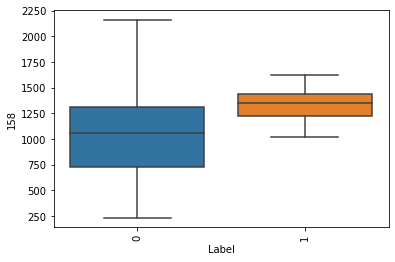

In [14]:
# Let's plot a few features that are highly correlated with the target 
sns.boxplot(x=df_train["Label"], y=df_train[158])
plt.xticks(rotation=90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

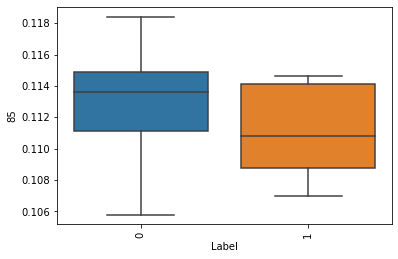

In [15]:
sns.boxplot(x=df_train["Label"], y=df_train[85])
plt.xticks(rotation=90)

**Scatter matrix plot**

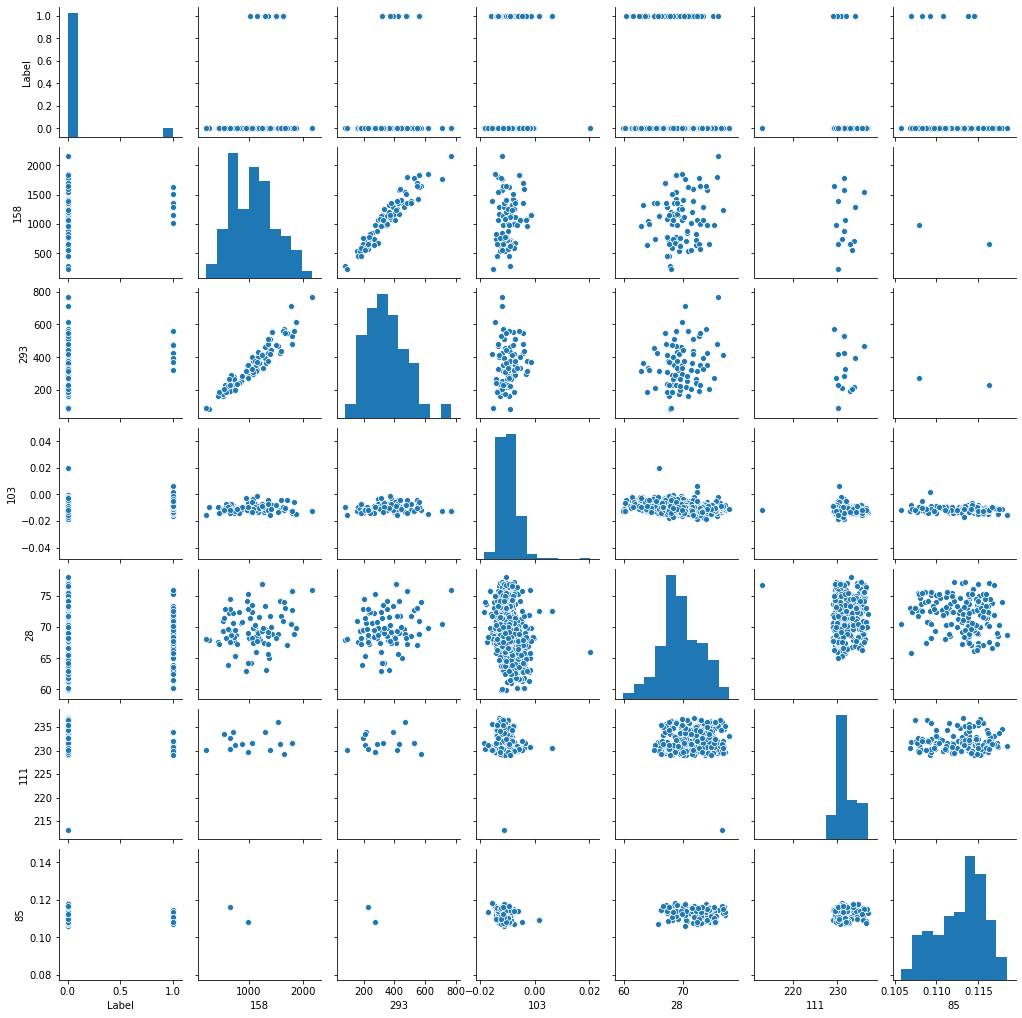

In [16]:
sns.pairplot(data=df_train,
            vars=["Label", 158, 293, 103, 28, 111, 85],
            height=2)

- Most of the features have close to normal distribution
- Some of the features appears to be correlated with each other (ex. feature 158 and 293). This may cause a colinearity problem when modeling. I'll attempt to reduce this in the 'feature selection section.

### Preprocessing of features

#### Missing data

In [17]:
# drop columns where more than 30% of the training set are NaN
drop_cols = df_train.columns[df_train.isnull().sum()>330]
print(drop_cols)

#drop from both training, tune and test sets
df_train_preprocessed = df_train.drop(drop_cols, axis=1)
df_tune_preprocessed = df_tune.drop(drop_cols, axis=1)
df_test_preprocessed = df_test.drop(drop_cols, axis=1)

# double check data dimensions after the drop
print(df_train.shape)
print(df_tune.shape)
print(df_test.shape)
print(df_train_preprocessed.shape)
print(df_tune_preprocessed.shape)
print(df_test_preprocessed.shape)

Index([ 72,  73,  85, 109, 110, 111, 112, 157, 158, 220, 244, 245, 246, 247,
       292, 293, 345, 346, 358, 382, 383, 384, 385, 492, 516, 517, 518, 519,
       578, 579, 580, 581],
      dtype='object')
(1096, 592)
(235, 592)
(236, 592)
(1096, 560)
(235, 560)
(236, 560)


In [18]:
# impute the rest of the missing values with mean
df_train_preprocessed = df_train_preprocessed.fillna(df_train_preprocessed.mean())
df_tune_preprocessed = df_tune_preprocessed.fillna(df_tune_preprocessed.mean())
df_test_preprocessed = df_test_preprocessed.fillna(df_test_preprocessed.mean())

In [19]:
# confirm no missing values after transformation
print(sum(df_train_preprocessed.isnull().sum()>0))
print(sum(df_tune_preprocessed.isnull().sum()>0))
print(sum(df_test_preprocessed.isnull().sum()>0))

0
0
0


#### Feature scaling

In [20]:
# pull target into arrays
y_train = df_train_preprocessed["Label"].to_numpy()
y_tune = df_tune_preprocessed["Label"].to_numpy()
y_test = df_test_preprocessed["Label"].to_numpy()

#drop target 
X_train = df_train_preprocessed.drop(["Label","Time"], axis=1)
X_tune = df_tune_preprocessed.drop(["Label","Time"], axis=1)
X_test = df_test_preprocessed.drop(["Label","Time"], axis=1)

# double check data dimensions after the drop
print(y_train.shape)
print(y_tune.shape)
print(y_test.shape)
print(X_train.shape)
print(X_tune.shape)
print(X_test.shape)

(1096,)
(235,)
(236,)
(1096, 558)
(235, 558)
(236, 558)


In [21]:
from sklearn.preprocessing import StandardScaler

# scale numeric features
sc = StandardScaler()
sc.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
# transform train and test
X_train_processed = pd.DataFrame(sc.transform(X_train), columns=X_train.columns)
X_tune_processed = pd.DataFrame(sc.transform(X_tune), columns=X_tune.columns)
X_test_processed = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

In [23]:
X_train_processed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,74,75,76,77,78,79,80,81,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,347,348,349,350,351,352,353,354,355,356,357,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,582,583,584,585,586,587,588,589
0,-0.412612,-0.446273,-0.431879,-0.667842,-0.052221,0.0,-0.535809,-0.026039,-1.437268,-0.352918,0.913885,0.169029,-1.888794,0.0,0.389550,-0.474160,0.152815,0.304693,-2.486009,0.187623,1.191357,-1.616935,-1.615471,0.151576,-0.078900,-0.684075,-0.882139,-1.351607,0.467274,-1.482312,-1.650716,1.988569,-0.102803,-0.634548,0.525827,-0.046140,-0.525835,0.531934,-0.445538,-0.423076,0.690860,-2.537289e-01,0.0,1.491756,0.032700,0.330437,1.231453,0.713051,-0.509958,0.0,1.139170,0.680561,0.0,0.609921,0.473583,0.198878,-1.324669,0.384607,-0.172597,-0.624605,1.584698,0.531744,-0.046186,0.556453,0.562701,0.455322,1.004824,-0.045708,-1.196852,0.0,0.487863,0.059345,-0.030275,-0.032472,-0.369650,1.041071,-0.603632,-0.341191,1.180307,0.464621,-1.701960,0.303559,-1.097024,-1.051940,0.321067,-2.731058,-1.011804e-15,0.000000,-2.200583,0.327625,-0.053823,0.141502,-1.564640,0.366487,0.0,-0.688992,0.066933,0.617791,-0.466315,1.721927,-0.090966,-0.070866,-0.336928,0.020217,-1.367551,1.168391,-0.463462,-0.076355,-0.201984,0.182699,0.132898,-7.650172,0.010499,-1.504587,-0.875901,0.283871,-0.556929,-0.577645,1.001600,-1.018582,0.294129,-0.352609,0.444239,-1.110166,-0.759411,-0.293112,-1.129096,-0.681910,2.901107,-1.233840,-1.767033,-0.451208,-0.345362,-0.043414,0.0,0.150338,-0.704380,-0.466607,1.548184,-0.112663,-0.016723,0.162700,0.0,-0.285787,-0.101069,-0.033554,-0.141138,0.672742,-0.127799,-0.403356,-0.497196,-0.762968,-0.919924,-0.505208,-0.675410,-0.314576,0.188788,-0.713176,-1.293768,-1.189181,-1.312927,0.642271,2.018473,-0.443640,-0.673224,-0.443610,1.257558,1.090413,-1.047910,0.0,0.0,1.312940,0.738575,1.449426,-1.283936,0.422928,-1.008911,0.0,-0.968603,0.841456,0.0,0.0,0.0,0.0,0.0,0.0,-0.430828,0.320413,0.199245,0.207021,-0.425101,0.134089,1.195869,0.424851,-0.368575,-0.052698,-0.224091,-0.030275,-0.085010,-1.279979,-0.030275,0.294837,-0.476167,0.958080,-0.85934

## Class Imbalance

As we found in the initial data load, the target is highly imbalanced. Only a small percentage (6.6%) of the cases have defects. I'll be using Synthetic Minority Oversampling Technique (SMOTE) to mitigate class imbalance.

In [24]:
# instantiate SMOTE object
from imblearn.over_sampling import SMOTE 

smt = SMOTE(random_state=SEED)

print(smt)

Using TensorFlow backend.


SMOTE(k_neighbors=5, n_jobs=None, random_state=2005, sampling_strategy='auto')


In [25]:
# fit SMOTE
X_train_res, y_train_res = smt.fit_resample(X_train_processed, y_train)

In [26]:
# data dimensions before and after SMOTE
print(X_train.shape)
print(X_train_res.shape)

(1096, 558)
(2046, 558)


## Feature Selection

**Wrapper Method**

In [27]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression

In [28]:
# let's try to keep top 50 features 
stepwise_selector = SFS(
    estimator=LogisticRegression(random_state=SEED), 
    k_features=50, #how many features to keep 
    forward=True, # forward selection
    scoring="roc_auc", 
    cv=None
)

stepwise_selector.fit(X_train_res, y_train_res)

SequentialFeatureSelector(clone_estimator=True, cv=None,
                          estimator=LogisticRegression(C=1.0, class_weight=None,
                                                       dual=False,
                                                       fit_intercept=True,
                                                       intercept_scaling=1,
                                                       l1_ratio=None,
                                                       max_iter=100,
                                                       multi_class='auto',
                                                       n_jobs=None,
                                                       penalty='l2',
                                                       random_state=2005,
                                                       solver='lbfgs',
                                                       tol=0.0001, verbose=0,
                                                       warm_start=Fals

In [29]:
# what are the final features selected
stepwise_selector.k_feature_names_

(22,
 53,
 56,
 58,
 59,
 62,
 63,
 66,
 71,
 75,
 84,
 89,
 90,
 100,
 101,
 102,
 104,
 117,
 121,
 127,
 129,
 130,
 138,
 146,
 161,
 183,
 197,
 204,
 249,
 278,
 298,
 310,
 333,
 341,
 344,
 349,
 355,
 428,
 436,
 460,
 471,
 485,
 510,
 520,
 521,
 553,
 575,
 586,
 587,
 589)

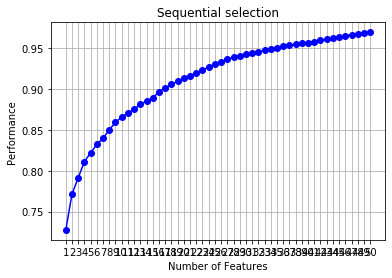

In [30]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(stepwise_selector.get_metric_dict(), kind=None)
plt.title("Sequential selection")
plt.grid()
plt.show()

With the top 50 features, performance of logistic regression starts leveling out. I'll be using these selected features for modeling in the next milestone.

## Milestone 1 Summary

In milestone 1, I prepared the manufacturing data for modeling by performing the following:
- Merged the feature and label datasets
- Split data into training/tuning/testing (70/15/15)
- Performed initial exploratory data analysis:
    - The label is highly imbalanced. Only a small percentage (6.6%) of the cases have defects.
    - All features are numeric.
    - Plotted scatter matrix for the features most correlated with the label. Most of those features have close to normal distribution. 
    - Some of the features appears to be correlated with each other (ex. feature 158 and 293). This may cause a colinearity problem when modeling. 
- Cleaned data by:
    - Removing features that have missing values in more than 30% of the dataset
    - Input mean for features with fewer missing values
    - Applied standard scalar to the features
- Addressed class imbalance problem using SMOTE
- Applied Wrapper forward selection to feature select:
    - Performance (using logistic regression and AOC curve as the error metric) started leveling off with the top 50 features

# Milestone 2

### Overview
In Milestone 2, I'll be building the following models to detect faulty products:
1. Decision Tree Model
2. Ensemble Model
3. SVM Model

In [31]:
# Keep only features that were selected using the wrapper method
selected_col = np.asarray(stepwise_selector.k_feature_names_)

X_train = X_train_res[selected_col]
X_tune = X_tune_processed[selected_col]
X_test = X_test_processed[selected_col]

# feature names
feature_names = X_train.columns

#check dimensions
print(X_train.shape)
print(X_tune.shape)
print(X_test.shape)
print(feature_names)

(2046, 50)
(235, 50)
(236, 50)
Index([ 22,  53,  56,  58,  59,  62,  63,  66,  71,  75,  84,  89,  90, 100,
       101, 102, 104, 117, 121, 127, 129, 130, 138, 146, 161, 183, 197, 204,
       249, 278, 298, 310, 333, 341, 344, 349, 355, 428, 436, 460, 471, 485,
       510, 520, 521, 553, 575, 586, 587, 589],
      dtype='object')


## Decision Tree Model

In [111]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [112]:
# grid search
grid_decision = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=SEED),
    param_grid={
        "criterion": ["entropy","gini"],
        "max_depth": [8, 9, 10, 11, 12, 13, 14, 15],
        "min_samples_leaf": [5, 10, 11, 12, 13, 14, 15, 16, 17,18, 19, 20, 25]
    },
    scoring="recall", #using recall as the scoring metric since we want to try to capture as much defects as we can
    n_jobs=10,
    cv=StratifiedKFold(n_splits=5, random_state=SEED),
    verbose=1, 
    refit=True 
)

# fit in training data
grid_decision.fit(X_train, y_train_res)

Fitting 5 folds for each of 208 candidates, totalling 1040 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   16.2s
[Parallel(n_jobs=10)]: Done 1040 out of 1040 | elapsed:   19.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2005, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=2005,
                                              splitter='best'),
             iid='deprecated', n_jobs=10,
       

In [113]:
# best estimator determined by GridSearchCV
estimator_decision_best = grid_decision.best_estimator_
print(estimator_decision_best)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2005, splitter='best')


In [114]:
# best hyper-parameters selected
print(grid_decision.best_params_)

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5}


The best hyperparamter for a decision tree model is an entropy classifier with max depth of 10 and min samples leaf of 5.

In [115]:
# predict probability on tune set
y_tune_decision_prob = estimator_decision_best.predict_proba(X_tune)[:,1]

# predict class label on tune set
y_tune_decision_pred = estimator_decision_best.predict(X_tune)

In [116]:
# print out confusion matrix
cm = confusion_matrix(y_true=y_tune, y_pred=y_tune_decision_pred)
print(cm)

[[186  37]
 [  5   7]]


In [117]:
# calculate accuracy 
accuracy_score(y_true=y_tune, y_pred=y_tune_decision_pred)

0.8212765957446808

In [118]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_tune, y_tune_decision_pred)

print('             Class 0   -   Class 1')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

             Class 0   -   Class 1
Precision: [0.97382199 0.15909091]
Recall   : [0.83408072 0.58333333]
F1       : [0.89855072 0.25      ]
Support  : [223  12]


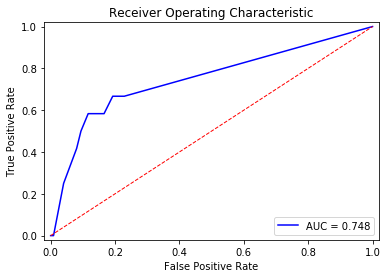

In [119]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_tune, y_score=y_tune_decision_prob)
roc_auc = roc_auc_score(y_true=y_tune, y_score=y_tune_decision_prob)

plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.show()

**Visualize decision tree**

In [120]:
import os
from sklearn.tree import export_graphviz
from IPython.display import Image
graphviz_path = "C:/Users/19173/Desktop/UW Data Science Class/Course 3/Milestones/Milestone 2/graphviz" 
def show_tree(out_name, model, feature_names):
    dotfile = open(out_name + ".dot", "w")
    export_graphviz(model, out_file=dotfile, filled=True, rounded=True, feature_names=feature_names)
    dotfile.close()
    os.environ["PATH"] += os.pathsep + graphviz_path
    os.system("dot -Tpng {}.dot -o {}.png".format(out_name, out_name))
    return(Image(filename=out_name + ".png", width=500, height=500))

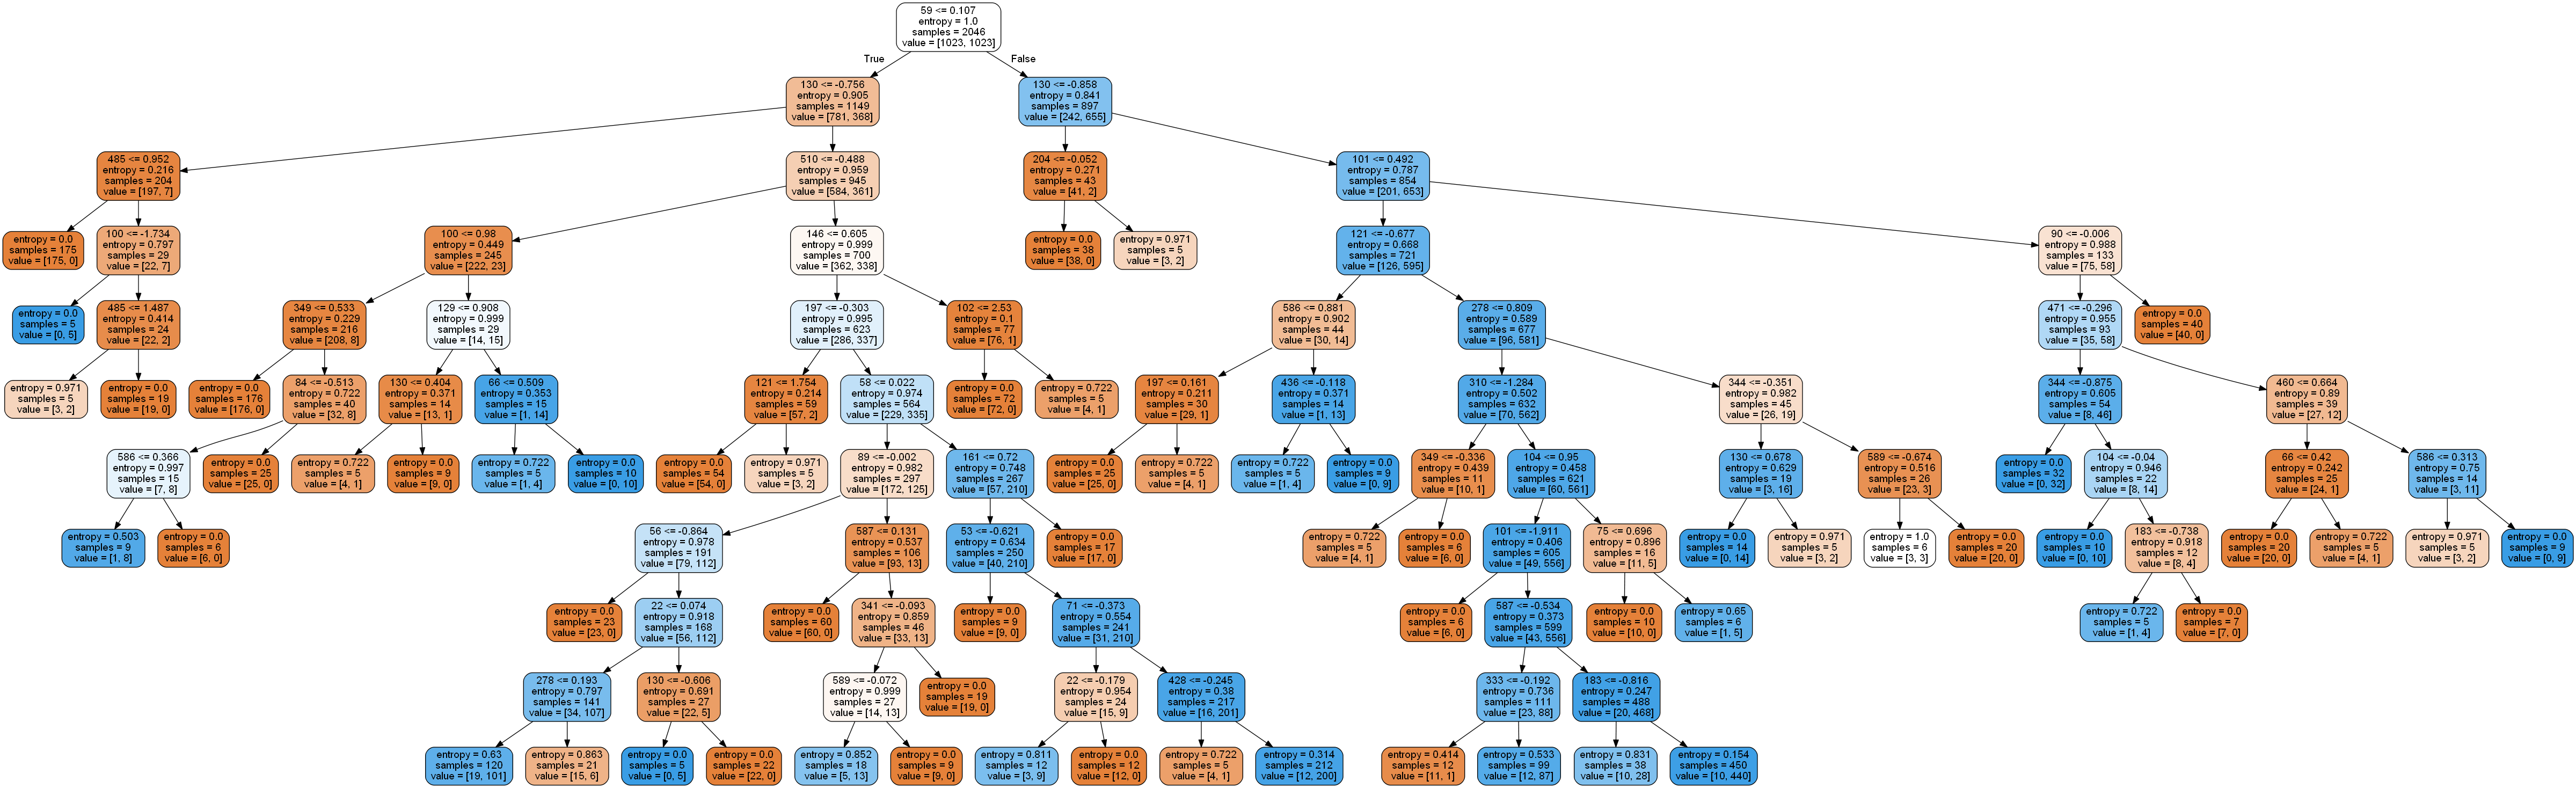

In [121]:
# plot using our own function
show_tree(out_name="decision_tree", model=estimator_decision_best, feature_names=feature_names)

### Decision Tree Model Results:
Using GridSearchCV, I found that the best hyperparamter for a decision tree model is an entropy classifier with max depth of 10 and min samples leaf of 5.

Using the best decision tree model, I predicted on the tune set. Below are the model results:
- Accuracy: 0.8213
- AUC:0.748
- Recall: 0.5833
- Precision: 0.1590
- F1 Score: 0.25

The features used to determine top level splits are: 59, 130, 485, 510, 204, and 101.

## Random Forest Model

In [122]:
from sklearn.ensemble import RandomForestClassifier

In [123]:
# grid search
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=SEED),
    param_grid={
        "n_estimators": [20, 30, 40, 45, 50, 60],
        "max_features": [0.05, 0.1, 0.15, 0.2],
        "criterion": ["entropy", "gini"],
        "max_depth": [10, 15, 20, 25, 30],
        "min_samples_leaf": [5, 10, 15, 20],
    },
    scoring="recall", #using recall as the scoring metric since we want to try to capture as much defects as we can
    n_jobs=10, #parallel processing
    cv=StratifiedKFold(n_splits=5, random_state=SEED),
    verbose=1,
    refit=True 
)
                           
# fit in training data
grid_rf.fit(X_train, y_train_res)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 260 tasks      | elapsed:   13.8s
[Parallel(n_jobs=10)]: Done 510 tasks      | elapsed:   34.7s
[Parallel(n_jobs=10)]: Done 860 tasks      | elapsed:   58.1s
[Parallel(n_jobs=10)]: Done 1310 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 1860 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 2510 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 3260 tasks      | elapsed:  3.6min
[Parallel(n_jobs=10)]: Done 4110 tasks      | elapsed:  4.3min
[Parallel(n_jobs=10)]: Done 4800 out of 4800 | elapsed:  4.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2005, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,...
                                              oob_score=False,
                                              random_state=2005, verbose=0,
                                              warm_s

In [124]:
# best estimator determined by GridSearchCV
estimator_rf_best = grid_rf.best_estimator_
print(estimator_rf_best)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features=0.2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=2005,
                       verbose=0, warm_start=False)


In [125]:
# best hyper-parameters selected
print(grid_rf.best_params_)

{'criterion': 'entropy', 'max_depth': 15, 'max_features': 0.2, 'min_samples_leaf': 5, 'n_estimators': 50}


The best hyper parameters for random forest is an entropy model with max_depth of 15, max_features of 0.2, min_samples_leaf of 5, and 50 n_estimators.

In [126]:
# predict probability on tune set
y_tune_rf_prob = estimator_rf_best.predict_proba(X_tune)[:,1]

# predict class label on tune set
y_tune_rf_pred = estimator_rf_best.predict(X_tune)

In [127]:
# print out confusion matrix
cm = confusion_matrix(y_true=y_tune, y_pred=y_tune_rf_pred)
print(cm)

[[213  10]
 [  9   3]]


In [128]:
# calculate accuracy 
accuracy_score(y_true=y_tune, y_pred=y_tune_rf_pred)

0.9191489361702128

In [129]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_tune, y_tune_rf_pred)

print('             Class 0   -   Class 1')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

             Class 0   -   Class 1
Precision: [0.95945946 0.23076923]
Recall   : [0.95515695 0.25      ]
F1       : [0.95730337 0.24      ]
Support  : [223  12]


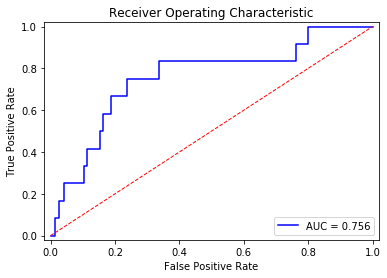

In [130]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_tune, y_score=y_tune_rf_prob)
roc_auc = roc_auc_score(y_true=y_tune, y_score=y_tune_rf_prob)

plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.show()

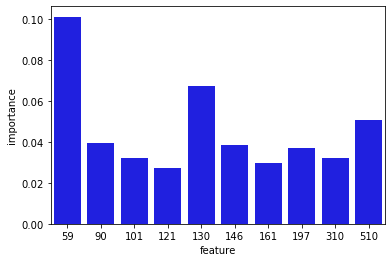

In [131]:
# plot feature importance
df_var_imp = pd.DataFrame({"feature": feature_names, 
                           "importance": estimator_rf_best.feature_importances_})
df_var_imp.sort_values(by="importance", ascending=False, inplace=True)

sns.barplot(y="importance", x="feature", data=df_var_imp.head(10), color="blue")

### Random Forest Model Results:
Using GridSearchCV, I found that the best hyper parameters for random forest is an entropy model with max_depth of 15, max_features of 0.2, min_samples_leaf of 5, and 50 n_estimators.

Using the best random forest model, I predicted on the tune set. Below are the model results:
- Accuracy: 0.9191
- AUC:0.756
- Recall: 0.25
- Precision: 0.23
- F1 Score: 0.24

The most important features are 59, 130, and 510.

## SVM Model

In [132]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.svm import SVC

In [134]:
# grid search
grid_SVC = GridSearchCV(
    estimator=SVC(probability=True, random_state=SEED, verbose=0),
    param_grid={
        "C": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.25, 0.5], #cost parameter
        "kernel": ["linear", "poly", "rbf"],
        "degree": [2, 3, 4, 5], #parameter for the polynomial kernel
        "gamma": ["scale", "auto"], #parameter for polynomial and rbf kernels
        },
    scoring="recall", #using recall as the scoring metric since we want to try to capture as much defects as we can
    n_jobs=10,
    cv=StratifiedKFold(n_splits=5, random_state=SEED),
    verbose=1,
    refit=True
)

# fit in training data, and select hyper-parameters in tune data
grid_SVC.fit(X_train, y_train_res)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   24.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed:  2.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2005, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=2005, shrinking=True,
                           tol=0.001, verbose=0),
             iid='deprecated', n_jobs=10,
             param_grid={'C': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.25, 0.5],
                         'degree': [2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=1)

In [135]:
# best estimator determined by GridSearchCV
estimator_SVC_best = grid_SVC.best_estimator_
print(estimator_SVC_best)

SVC(C=0.25, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=2005, shrinking=True, tol=0.001,
    verbose=0)


In [136]:
# best hyper-parameters selected
print(grid_SVC.best_params_)

{'C': 0.25, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


The best hyper parameters for SVC is a poly kernel with c of 0.25, degree 2, and scale gamma.

In [137]:
# predict probability on tune set
y_tune_SVC_prob = estimator_SVC_best.predict_proba(X_tune)[:,1]

# predict class label on tune set
y_tune_SVC_pred = estimator_SVC_best.predict(X_tune)

In [138]:
# print out confusion matrix
cm = confusion_matrix(y_true=y_tune, y_pred=y_tune_SVC_pred)
print(cm)

[[189  34]
 [  8   4]]


In [139]:
# calculate accuracy 
accuracy_score(y_true=y_tune, y_pred=y_tune_SVC_pred)

0.8212765957446808

In [140]:
precision, recall, f1, support = precision_recall_fscore_support(y_tune, y_tune_SVC_pred)

print('             Class 0   -   Class 1')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

             Class 0   -   Class 1
Precision: [0.95939086 0.10526316]
Recall   : [0.84753363 0.33333333]
F1       : [0.9  0.16]
Support  : [223  12]


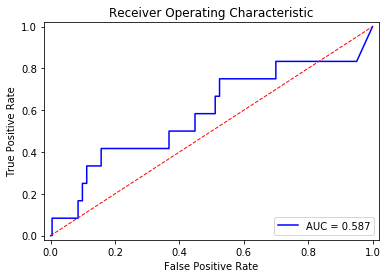

In [141]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_tune, y_score=y_tune_SVC_prob)
roc_auc = roc_auc_score(y_true=y_tune, y_score=y_tune_SVC_prob)

plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.show()

### AVC Model Results:
Using GridSearchCV, I found that the best hyperparamter for a SVC model is a poly kernel with c of 0.25, degree 2, and scale gamma.

Using the best SVC model, I predicted on the tune set. Below are the model results:
- Accuracy: 0.8213
- AUC:0.587
- Recall: 0.3333
- Precision:0.1053
- F1 Score: 0.16

# Evaluation of Models

**Model Results**

| Metric | Decision Tree  | Random Forest  | SVC  |
|------|------|------|------|
|   Accuracy  | 0.8213| 0.9191| 0.8213|
|   AUC  | 0.748| 0.756| 0.587|
|   Recall  | 0.5833| 0.25| 0.3333|
|   Precision  | 0.1590| 0.23| 0.1053|
|   F1 Score  | 0.25| 0.24| 0.16|

**Random Forest model** (entropy with max_depth of 15, max_features of 0.2, min_samples_leaf of 5, and 50 n_estimators) performed the best in terms of both accuracy and F1 score. I'll be using this model to predict on the test set.

## Predict on test set

In [142]:
# predict probability on test set
y_test_prob = estimator_rf_best.predict_proba(X_test)[:,1]

# predict class label on test set
y_test_pred = estimator_rf_best.predict(X_test)

In [143]:
# print out confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(cm)

[[203  14]
 [ 16   3]]


In [144]:
# calculate accuracy 
accuracy_score(y_true=y_test, y_pred=y_test_pred)

0.8728813559322034

In [145]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred)

print('             Class 0   -   Class 1')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

             Class 0   -   Class 1
Precision: [0.92694064 0.17647059]
Recall   : [0.93548387 0.15789474]
F1       : [0.93119266 0.16666667]
Support  : [217  19]


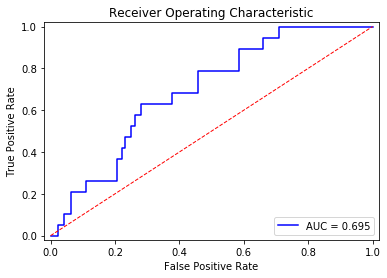

In [146]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_test_prob)
roc_auc = roc_auc_score(y_true=y_test, y_score=y_test_prob)

plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.show()

With much lower accuracy score of 0.8729 and F1 score of 0.1667, it appears that the random forest model did not generalize well to the test set.

## Milestone 2 Summary

In Milestone 2, I built the following models to detect faulty products:

1. Decision Tree Model
2. Ensemble Model: Random Forest
3. SVM Model

Below are the results (on the tune set):

| Metric | Decision Tree  | Random Forest  | SVC  |
|------|------|------|------|
|   Accuracy  | 0.8213| 0.9191| 0.8213|
|   AUC  | 0.748| 0.756| 0.587|
|   Recall  | 0.5833| 0.25| 0.3333|
|   Precision  | 0.1590| 0.23| 0.1053|
|   F1 Score  | 0.25| 0.24| 0.16|

**Random Forest model** (entropy with max_depth of 15, max_features of 0.2, min_samples_leaf of 5, and 50 n_estimators) performed the best in terms of both accuracy and F1 score. 

However it did not generalize as well to the test set. The model prediction on the test set had an accuracy score of 0.8729 and F1 score of 0.1667.

# Milestone 3

### Overview
In Milestone 3, I'll be building the following models to detect faulty products:
1. Simple Neural Network
2. DNN model

## Simple Neural Network

In [46]:
import tensorflow as tf
from tensorflow import keras

In [47]:
simple_model = keras.Sequential([
    keras.layers.Dense(64, input_dim=X_train.shape[1], activation="relu"), 
    keras.layers.Dense(1, activation="sigmoid") 
])

In [48]:
# summary of model object
simple_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                3264      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________


In [49]:
simple_model.compile(optimizer="adam", 
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [50]:
simple_history = simple_model.fit(X_train, 
                    y_train_res, 
                    batch_size=16,
                    epochs=40,
                    verbose=1,
                    validation_data=(X_tune, y_tune)
)

Train on 2046 samples, validate on 235 samples
Epoch 1/40
2046/2046 [==============================] - 0s 101us/sample - loss: 0.6283 - acc: 0.6965 - val_loss: 0.5570 - val_acc: 0.7404
Epoch 2/40
2046/2046 [==============================] - 0s 59us/sample - loss: 0.3690 - acc: 0.8817 - val_loss: 0.4740 - val_acc: 0.8085
Epoch 3/40
2046/2046 [==============================] - 0s 55us/sample - loss: 0.2749 - acc: 0.9198 - val_loss: 0.4505 - val_acc: 0.8340
Epoch 4/40
2046/2046 [==============================] - 0s 62us/sample - loss: 0.2163 - acc: 0.9457 - val_loss: 0.4533 - val_acc: 0.8681
Epoch 5/40
2046/2046 [==============================] - 0s 65us/sample - loss: 0.1738 - acc: 0.9633 - val_loss: 0.4662 - val_acc: 0.8553
Epoch 6/40
2046/2046 [==============================] - 0s 75us/sample - loss: 0.1441 - acc: 0.9682 - val_loss: 0.4733 - val_acc: 0.8553
Epoch 7/40
2046/2046 [==============================] - 0s 79us/sample - loss: 0.1171 - acc: 0.9790 - val_loss: 0.4860 - val_acc: 

In [51]:
# output
loss_tune, acc_tune = simple_model.evaluate(X_tune, y_tune)

print("Tune set accuracy:", acc_tune)

235/235 [==============================] - 0s 25us/sample - loss: 0.9196 - acc: 0.9064
Tune set accuracy: 0.906383


In [52]:
# predict
y_tune_prob = simple_model.predict(X_tune)
y_tune_pred = (simple_model.predict(X_tune) >= 0.5).astype("int32")

In [53]:
# print out confusion matrix
cm = confusion_matrix(y_true=y_tune, y_pred=y_tune_pred)
print(cm)

[[211  12]
 [ 10   2]]


In [54]:
# calculate accuracy 
accuracy_score(y_true=y_tune, y_pred=y_tune_pred)

0.9063829787234042

In [55]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_tune, y_tune_pred)

print('             Class 0   -   Class 1')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

             Class 0   -   Class 1
Precision: [0.95475113 0.14285714]
Recall   : [0.94618834 0.16666667]
F1       : [0.95045045 0.15384615]
Support  : [223  12]


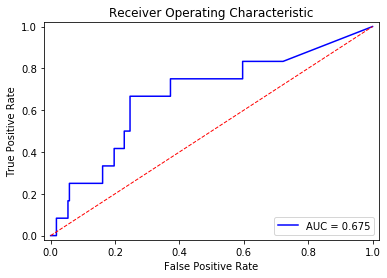

In [56]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_tune, y_score=y_tune_prob)
roc_auc = roc_auc_score(y_true=y_tune, y_score=y_tune_prob)

plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.show()

### Neural Network Model Results:
Below are the model results on the tune set:
- Accuracy: 0.90638
- AUC:0.675
- Recall: 0.1667
- Precision: 0.1428
- F1 Score: 0.1538

## DNN Model

In [57]:
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import sys
import talos

**Deep learning model function**

In [68]:
model = keras.Sequential([
    keras.layers.Dense(64, input_dim=X_train.shape[1], activation="relu"), 
    keras.layers.Dense(32, activation="relu"), # second hidden layer
    keras.layers.Dense(32, activation="relu"), # second hidden layer
    keras.layers.Dense(1, activation="sigmoid") 
])

In [69]:
# summary of model object
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                3264      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 6,433
Trainable params: 6,433
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [71]:
history = simple_model.fit(X_train, 
                    y_train_res, 
                    batch_size=16,
                    epochs=40,
                    verbose=1,
                    validation_data=(X_tune, y_tune)
)

Train on 2046 samples, validate on 235 samples
Epoch 1/40
2046/2046 [==============================] - ETA: 0s - loss: 0.0029 - acc: 1.000 - ETA: 0s - loss: 0.0018 - acc: 1.000 - ETA: 0s - loss: 0.0018 - acc: 1.000 - 0s 74us/sample - loss: 0.0017 - acc: 1.0000 - val_loss: 0.9335 - val_acc: 0.9064
Epoch 2/40
2046/2046 [==============================] - ETA: 0s - loss: 0.0025 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.000 - 0s 61us/sample - loss: 0.0016 - acc: 1.0000 - val_loss: 0.9473 - val_acc: 0.9064
Epoch 3/40
2046/2046 [==============================] - ETA: 0s - loss: 5.2696e-04 - acc: 1.000 - ETA: 0s - loss: 0.0014 - acc: 1.0000    - ETA: 0s - loss: 0.0014 - acc: 1.000 - 0s 74us/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.9569 - val_acc: 0.9064
Epoch 4/40
2046/2046 [==============================] - ETA: 0s - loss: 0.0016 - acc: 1.000 - ETA: 0s - loss: 0.0014 - acc: 1.000 - ETA: 0s - loss: 0.0013 - acc: 1.000 - 0s 74us/sample - loss:

In [72]:
# output
loss_tune, acc_tune = simple_model.evaluate(X_tune, y_tune)

print("Tune set accuracy:", acc_tune)

235/235 [==============================] - ETA: 0s - loss: 5.6944 - acc: 0.750 - 0s 34us/sample - loss: 1.3604 - acc: 0.9064
Tune set accuracy: 0.906383


In [73]:
# predict
y_tune_prob = simple_model.predict(X_tune)
y_tune_pred = (simple_model.predict(X_tune) >= 0.5).astype("int32")

In [74]:
# print out confusion matrix
cm = confusion_matrix(y_true=y_tune, y_pred=y_tune_pred)
print(cm)

[[212  11]
 [ 11   1]]


In [75]:
# calculate accuracy 
accuracy_score(y_true=y_tune, y_pred=y_tune_pred)

0.9063829787234042

In [76]:
precision, recall, f1, support = precision_recall_fscore_support(y_tune, y_tune_pred)

print('             Class 0   -   Class 1')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

             Class 0   -   Class 1
Precision: [0.95067265 0.08333333]
Recall   : [0.95067265 0.08333333]
F1       : [0.95067265 0.08333333]
Support  : [223  12]


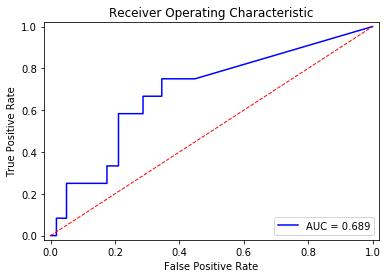

In [77]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_tune, y_score=y_tune_prob)
roc_auc = roc_auc_score(y_true=y_tune, y_score=y_tune_prob)

plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.show()

### Deep Neural Network Model Results:
Below are the model results on the tune set:
- Accuracy: 0.90638
- AUC:0.689
- Recall: 0.0833
- Precision: 0.0833
- F1 Score: 0.0833

Accuracy is the same, but AUC is slightly better. 

## Milestone 3 Summary

In Milestone 3, I built the following models to detect faulty products:

1. Simple Neural Network
2. Deep Neural Network

Below are the results (on the tune set):

| Metric | Simple NN  | DNN  |
|------|------|------|
|   Accuracy  | 0.90638| 0.90638|
|   AUC  | 0.675| 0.689|
|   Recall  | 0.1667| 0.0833|
|   Precision  | 0.1428| 0.0833|
|   F1 Score  | 0.1538| 0.0833|

While the DNN did slightly better in terms of AUC, Random Forest (from Milestone 2) is still the better option with accuracy of 0.9191 and AUC of 0.756 on the tune set. 